In [1]:
# Imports
import os
import sys

project_root = os.path.dirname(os.path.abspath(""))
sys.path.append(project_root)
import aiohttp
import data_processing.database as database
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_processing.scrape_user_ratings import get_user_ratings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    KFold,
    train_test_split,
)
from xgboost import XGBRegressor

In [2]:
# Crawl Letterboxd
user = "pbreck"
async with aiohttp.ClientSession() as session:
    user_df, _ = await get_user_ratings(user, session)

Leave the World Behind
Leave the World Behind is not rated by pbreck
Society of the Snow
Priscilla
Priscilla is not rated by pbreck
Poor Things
All of Us Strangers
Saltburn
Saltburn is not rated by pbreck
Oppenheimer
Killers of the Flower Moon
Bottoms
Bottoms is not rated by pbreck
Theater Camp
Theater Camp is not rated by pbreck
Dune
Dune is not rated by pbreck
Knives Out
Knives Out is not rated by pbreck
Midsommar
Midsommar is not rated by pbreck
Parasite
Parasite is not rated by pbreck
Hereditary
Hereditary is not rated by pbreck
Lady Bird
Lady Bird is not rated by pbreck
The Florida Project
Get Out
Get Out is not rated by pbreck
Call Me by Your Name
Call Me by Your Name is not rated by pbreck
The Age of Adaline
Gone Girl
Gone Girl is not rated by pbreck
The Grand Budapest Hotel
The Grand Budapest Hotel is not rated by pbreck
Black Swan
Black Swan is not rated by pbreck
Fantastic Mr. Fox
Fantastic Mr. Fox is not rated by pbreck
(500) Days of Summer
Pride & Prejudice
Pride & Prejudic

In [11]:
# Model Evaluation
def train_model(user_df, modelType="RF", verbose=False):

    # creates user feature data
    X = user_df.drop(columns=["title", "user_rating", "liked", "url", "username"])

    # creates user target data
    y = user_df["user_rating"]

    # creates train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )

    # creates test-validation split
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, random_state=0
    )

    # initializes recommendation model
    if modelType == "XG":
        model = XGBRegressor(
            enable_categorical=True, n_estimators=200, max_depth=3, learning_rate=0.05
        )
        X_train["movie_id"] = X_train["movie_id"].astype("category")
        X_test["movie_id"] = X_test["movie_id"].astype("category")
        X_val["movie_id"] = X_val["movie_id"].astype("category")
        # param_grid = {
        #     "n_estimators": [50, 100, 200],
        #     "max_depth": [None, 3, 6, 9],
        #     "learning_rate": [0.05, 0.1, 0.2, 0.3],
        # }
        # grid_search = GridSearchCV(
        #     model, param_grid, cv=5, scoring="neg_mean_squared_error"
        # )
        # grid_search.fit(X_train, y_train)
        # print("best params", grid_search.best_params_)
        # model = grid_search.best_estimator_
    elif modelType == "RF":
        model = RandomForestRegressor(
            random_state=0, max_depth=10, min_samples_split=10, n_estimators=100
        )
        # param_grid = {
        #     "n_estimators": [50, 100, 200],
        #     "max_depth": [None, 10, 20],
        #     "min_samples_split": [2, 5, 10],
        # }
        # grid_search = GridSearchCV(
        #     model, param_grid, cv=5, scoring="neg_mean_squared_error"
        # )
        # grid_search.fit(X_train, y_train)
        # print("best params", grid_search.best_params_)
        # model = grid_search.best_estimator_

    # performs k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_results = cross_val_score(
        model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"
    )
    mse_cv = -cv_results.mean()

    # fits recommendation model on user training data
    model.fit(X_train, y_train)

    # calculates mse on test data
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # calculates mse on validation data
    y_pred_val = model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_pred_val)

    results_df = pd.DataFrame(
        {"actual_user_rating": y_val, "predicted_user_rating": y_pred_val.flatten()}
    )

    # prints accuracy evaluation values
    if verbose:
        print("Mean Squared Error with 5-fold Cross Validation:", mse_cv)
        print("Mean Squared Error on Test Set:", mse_test)
        print("Mean Squared Error on Validation Set:", mse_val)
        print(results_df)

    return model, mse_cv, mse_test, mse_val


async def single_user_evaluation(user, modelType, session, verbose=False):
    user_df, _ = await get_user_ratings(user, session, verbose)
    user_df["movie_id"] = user_df["movie_id"].astype("int")
    user_df["url"] = user_df["url"].astype("string")
    user_df["username"] = user_df["username"].astype("string")
    print(user_df)
    movie_data = database.get_movie_data()
    movie_data["title"] = movie_data["title"].astype("string")
    movie_data["url"] = movie_data["url"].astype("string")
    processed_user_df = user_df.merge(movie_data, how="left", on=["movie_id", "url"])
    train_model(processed_user_df, modelType, verbose=True)


async def all_user_evaluation(modelType, session, verbose=False):

    # gets list of users from database
    users = database.get_users_in_db()

    # gets movie data from database
    movie_data = database.get_movie_data()
    movie_data["title"] = movie_data["title"].astype("string")
    movie_data["url"] = movie_data["url"].astype("string")

    # calculates mses for cross-val, test, and val for each model
    cv_mses = []
    test_mses = []
    val_mses = []
    for user in users:
        user_df, _ = await get_user_ratings(user, session, verbose)
        user_df["movie_id"] = user_df["movie_id"].astype("int")
        user_df["url"] = user_df["url"].astype("string")
        user_df["username"] = user_df["username"].astype("string")
        processed_user_df = user_df.merge(
            movie_data, how="left", on=["movie_id", "url"]
        )
        _, mse_cv, mse_test, mse_val = train_model(processed_user_df, modelType)
        cv_mses.append(mse_cv)
        test_mses.append(mse_test)
        val_mses.append(mse_val)

    # adds row containing average
    users.append("average")
    cv_mses.append(np.mean(cv_mses))
    test_mses.append(np.mean(test_mses))
    val_mses.append(np.mean(val_mses))

    # adds row containing std
    users.append("std")
    cv_mses.append(np.std(cv_mses))
    test_mses.append(np.std(test_mses))
    val_mses.append(np.std(val_mses))

    # stores accuracy evaluations in dataframe
    accuracy_df = pd.DataFrame(
        {
            "User": users,
            f"{modelType} Cross-Val MSE": cv_mses,
            f"{modelType} Test MSE": test_mses,
            f"{modelType} Val MSE": val_mses,
        }
    )

    return accuracy_df


def plot_accuracies(distributions):
    x = np.linspace(0, 2, 1000)

    # plots overlay of test mse pdfs and val mse pdfs for all models
    for plotOf in ["cross_val", "test", "val"]:
        plt.figure(figsize=(6, 3))
        for model, mse_data in distributions.items():
            mse_mean = np.mean(mse_data[f"{plotOf}_mse"])
            mse_std = np.std(mse_data[f"{plotOf}_mse"])
            mse_pdf = (1 / (mse_std * np.sqrt(2 * np.pi))) * np.exp(
                -((x - mse_mean) ** 2) / (2 * mse_std**2)
            )
            plt.plot(x, mse_pdf, label=model + f" {plotOf.title()} MSE")

        plt.title(f"Normal Distribution of {plotOf.title()} MSE for Each Model")
        plt.xlabel(f"{plotOf.title()} MSE")
        plt.ylabel("Probability Density")
        plt.legend()
        plt.grid(True)
        plt.show()


async def all_user_all_model_evaluation(session):
    modelTypes = ["XG", "RF"]

    # initialize empty distributions
    distributions = {
        "XG": {"cross_val_mse": (), "test_mse": (), "val_mse": ()},
        "RF": {"cross_val_mse": (), "test_mse": (), "val_mse": ()},
    }
    for m in modelTypes:

        # gets the accuracy values of a particular model for all users
        accuracy_df = await all_user_evaluation(m, session)

        # stores mean and std of cross-val mse
        cross_val_mean = (
            accuracy_df[accuracy_df["User"] == "average"][f"{m} Cross-Val MSE"],
        )
        cross_val_std = (
            accuracy_df[accuracy_df["User"] == "std"][f"{m} Cross-Val MSE"],
        )
        distributions[m]["cross_val_mse"] = (cross_val_mean, cross_val_std)

        # stores mean and std of test mse
        test_mean = (accuracy_df[accuracy_df["User"] == "average"][f"{m} Test MSE"],)
        test_std = (accuracy_df[accuracy_df["User"] == "std"][f"{m} Test MSE"],)
        distributions[m]["test_mse"] = (test_mean, test_std)

        # stores mean and std of val mse
        val_mean = (accuracy_df[accuracy_df["User"] == "average"][f"{m} Val MSE"],)
        val_std = (accuracy_df[accuracy_df["User"] == "std"][f"{m} Val MSE"],)
        distributions[m]["val_mse"] = (val_mean, val_std)

    # plots the accuracy evaluation values for all distributions
    plot_accuracies(distributions)

    return distributions

In [12]:
# Single User Evaluation
async with aiohttp.ClientSession() as session:
    await single_user_evaluation("victorverma", "RF", session)


successfully updated victorverma's ratings in database

successfully updated movie urls in database

scraped victorverma's movie data in 7.6118098990409635 seconds
      movie_id  user_rating  liked  \
0       834656          3.5      0   
1       488751          4.0      0   
2       617443          5.0      0   
3      1072790          3.0      0   
4      1113346          2.0      0   
...        ...          ...    ...   
1154     51238          4.0      0   
1155     73572          0.5      0   
1156     51471          3.5      0   
1157     94866          3.5      0   
1158     51377          3.5      0   

                                                    url     username  
0          https://letterboxd.com//film/civil-war-2024/  victorverma  
1              https://letterboxd.com//film/monkey-man/  victorverma  
2           https://letterboxd.com//film/dune-part-two/  victorverma  
3           https://letterboxd.com//film/war-game-2024/  victorverma  
4             https://l

In [14]:
# All User Evaluation
async with aiohttp.ClientSession() as session:
    evaluations = await all_user_evaluation("RF", session)
    print(f"\n{evaluations}")


successfully updated chels33's ratings in database

successfully updated movie urls in database

scraped chels33's movie data in 2.3702154640341178 seconds

successfully updated harryzielinski's ratings in database

successfully updated movie urls in database

scraped harryzielinski's movie data in 1.3949383670114912 seconds

successfully updated hgrosse's ratings in database

successfully updated movie urls in database

scraped hgrosse's movie data in 2.0292996549978852 seconds

successfully updated jconn8's ratings in database

successfully updated movie urls in database

scraped jconn8's movie data in 4.707930796954315 seconds

successfully updated juliamassey's ratings in database

successfully updated movie urls in database

scraped juliamassey's movie data in 3.2309777510236017 seconds

successfully updated mbooher's ratings in database

successfully updated movie urls in database

scraped mbooher's movie data in 1.7721903889905661 seconds

successfully updated obiravioli's rati


successfully updated chels33's ratings in database

successfully updated movie urls in database

scraped chels33's movie data in 2.5083588790148497 seconds

successfully updated harryzielinski's ratings in database

successfully updated movie urls in database

scraped harryzielinski's movie data in 1.3635657540289685 seconds

successfully updated hgrosse's ratings in database

successfully updated movie urls in database

scraped hgrosse's movie data in 2.5055039150174707 seconds

successfully updated jconn8's ratings in database

successfully updated movie urls in database

scraped jconn8's movie data in 4.830066627007909 seconds

successfully updated juliamassey's ratings in database

successfully updated movie urls in database

scraped juliamassey's movie data in 3.534370235982351 seconds

successfully updated mbooher's ratings in database

successfully updated movie urls in database

scraped mbooher's movie data in 1.5878803019877523 seconds

successfully updated obiravioli's ratin

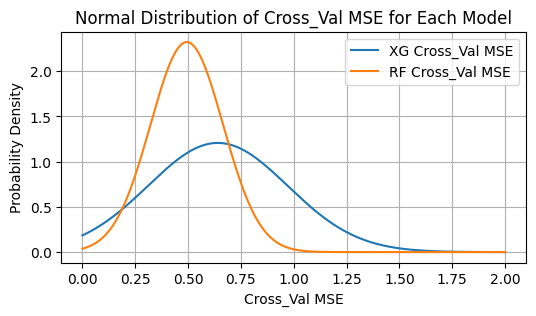

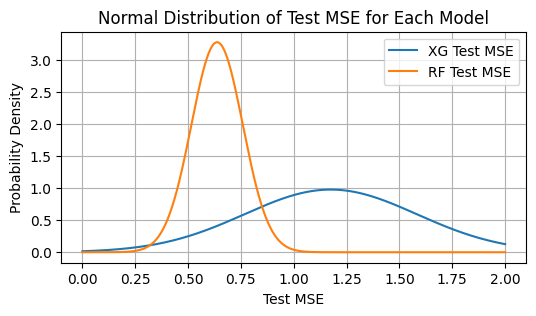

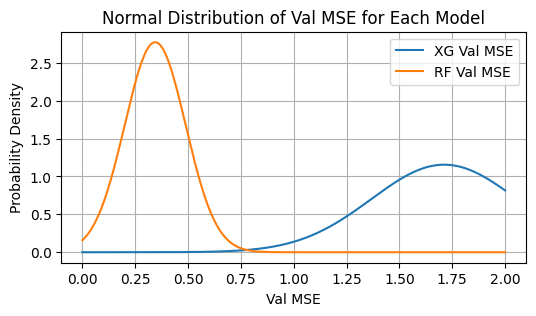

In [15]:
# All User and Model Evaluation
async with aiohttp.ClientSession() as session:
    await all_user_all_model_evaluation(session)